# SimplyP v.0.1 (alpha)

This notebook demonstrates basic usage of the [SimplyP model](https://github.com/LeahJB/SimplyP). The model is applied in

> Jackson-Blake LA, Sample JE, Wade AJ, Helliwell RC, Skeffington RA. 2017. *Are our dynamic water quality models too complex? A comparison of a new parsimonious phosphorus model, SimplyP, and INCA-P*. Water Resources Research, **53**, 5382–5399. [doi:10.1002/2016WR020132](http://onlinelibrary.wiley.com/doi/10.1002/2016WR020132/abstract;jsessionid=7E1F1066482B9FFDBC29BA6B5A80042C.f04t01)

and a full description is provided in the [Supplementary Information](http://onlinelibrary.wiley.com/store/10.1002/2016WR020132/asset/supinfo/wrcr22702-sup-0001-2016WR020132-s01.pdf?v=1&s=fc5ee61527c9fc914b4c14b35562f30b85d3c927). All code is [available online](https://github.com/LeahJB/SimplyP) under an [MIT licence](https://github.com/LeahJB/SimplyP/blob/Hydrology_Model/LICENSE).

## Tarland Burn example

This example uses data from the Tarland Burn in Aberdeenshire. Input data files, in the format required by SimplyP, can be found [here](https://github.com/LeahJB/SimplyP/tree/Hydrology_Model/Example_Data).

### Instructions for running the model

1. Download [the repository](https://github.com/LeahJB/SimplyP) and open the model setup Excel file, which is located in *Example_Data/Parameters_v0-1A_Tarland.xlsx*. The 'Readme' sheet includes further instructions but, as a minimum, you will need to **modify the file and folder paths** in the 'Setup' sheet to match those on your system. <br><br>

2. Provide the full file path to the Excel parameter file in the notebook cell below and select the figure display option (further details are provided below, in the 'User input' cell) <br><br>

3. Select 'Cell' (from the toolbar above) followed by 'Run all' <br><br>

4. Wait, and then check that the model has run. The model will output results (stats and graphs) in this notebook once it has finished, and it will save any files of model output that you have requested be saved (using the 'Setup' parameters sheet in the parameters Excel file). You can keep a tab on whether or not the model is still running by looking at CPU usage via the task manager <br><br>

5. Check that there are no pink warning messages below any of the code cells. If running the model produces warnings, it is likely that one of your parameter values is too small or large - check your values against the recommended ranges. Alternatively, there may be a problem with your input data <br><br>

6. Model output may be saved to files (csvs and images) if the setup parameter options for saving to file are selected. Regardless, results are output in this notebook below - scroll down to see graphs and stats.

If the model does not run, scroll down this notebook to look for error messages. If there is one, read it to see if it relates to your input data or parameters, which may be in the wrong format or contain some other inconsistencies which are checked for by the model (e.g. land use fractions must sum to 1, the start and end dates in the Setup parameters sheet may be in the wrong format, etc.). Please report other error messages by [submitting a pull request via GitHub](https://github.com/LeahJB/SimplyP/pulls) or emailing Leah Jackson-Blake (<ljb@niva.no>).

### 1. User input

* **Provide the full file path to the excel parameter file in the cell below**<br>
The file path should be encased within apostrophes, with the letter r before the first apostrophe (to indicate a 'raw' string)
e.g. `params_fpath = r'D:\ModelInputs\myParamFile.xlsx'`


* **Set plotting display options**<br>
If you primarily want to view results in this notebook, rather than save them to file, then set the fig_display_type option in the cell below to 'notebook'. Otherwise, set to 'paper'. This controls the plot figure size and font size

In [1]:
%matplotlib inline
import simply_p as sp

In [2]:
# Path to the setup Excel file
params_fpath = (r'C:\Data\James_Work\Staff\Leah_JB\SimplyP_Code\SimplyP'
                r'\Example_Data\Parameters_v0-1A_Tarland.xlsx')

# Plotting options: either 'paper' or 'notebook'
fig_display_type = 'notebook'

### 2. Read input data

The function `sp.read_input_data()` reads the Excel setup file and the datasets specified within it.

In [3]:
# Read inputs
p_SU, dynamic_options, p, p_LU, p_SC, met_df, obs_dict = sp.read_input_data(params_fpath)

### 3. Run the model

The input data is passed to the model function. After running, check there are no pink warning messages below the code cell: warning boxes likely suggest the ODE solver did not run propery, perhaps due to issues with the input parameters.

**Note:** If calibrating (`run_mode=='cal'`), the $Kf$ parameter (the soil sorption coefficient) will be estimated and printed at the end of the run. This can then be used for validation/scenarios.

In [4]:
# Run model
df_TC_dict, df_R_dict, Kf, ode_output_dict = sp.run_simply_p(met_df, p_SU, p_LU,
                                                             p_SC, p, dynamic_options, 
                                                             p_SU.inc_snowmelt)

Kf (the soil P sorption coefficient; mm/kg): 0.000113152804642


### 4. Explore model output

The following code cells summarise the model output, saving results to csv or as graphs.

#### 4.1. Results from snow module

thde snow module is only relevant if it was called during the model run (i.e. `inc_snowmelt=='y'` in the setup Excel file).

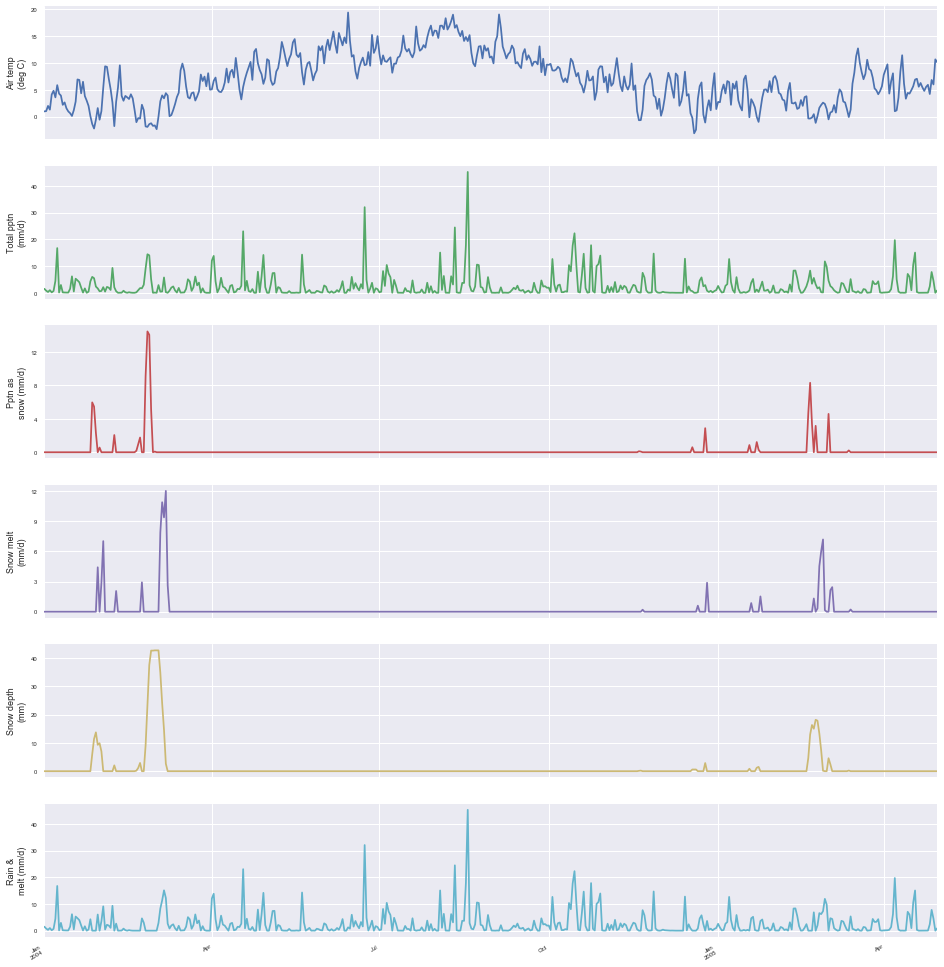

In [5]:
# Plot snowfall/melt
sp.plot_snow(met_df, p_SU, fig_display_type)

#### 4.2. Results from terrestrial processing

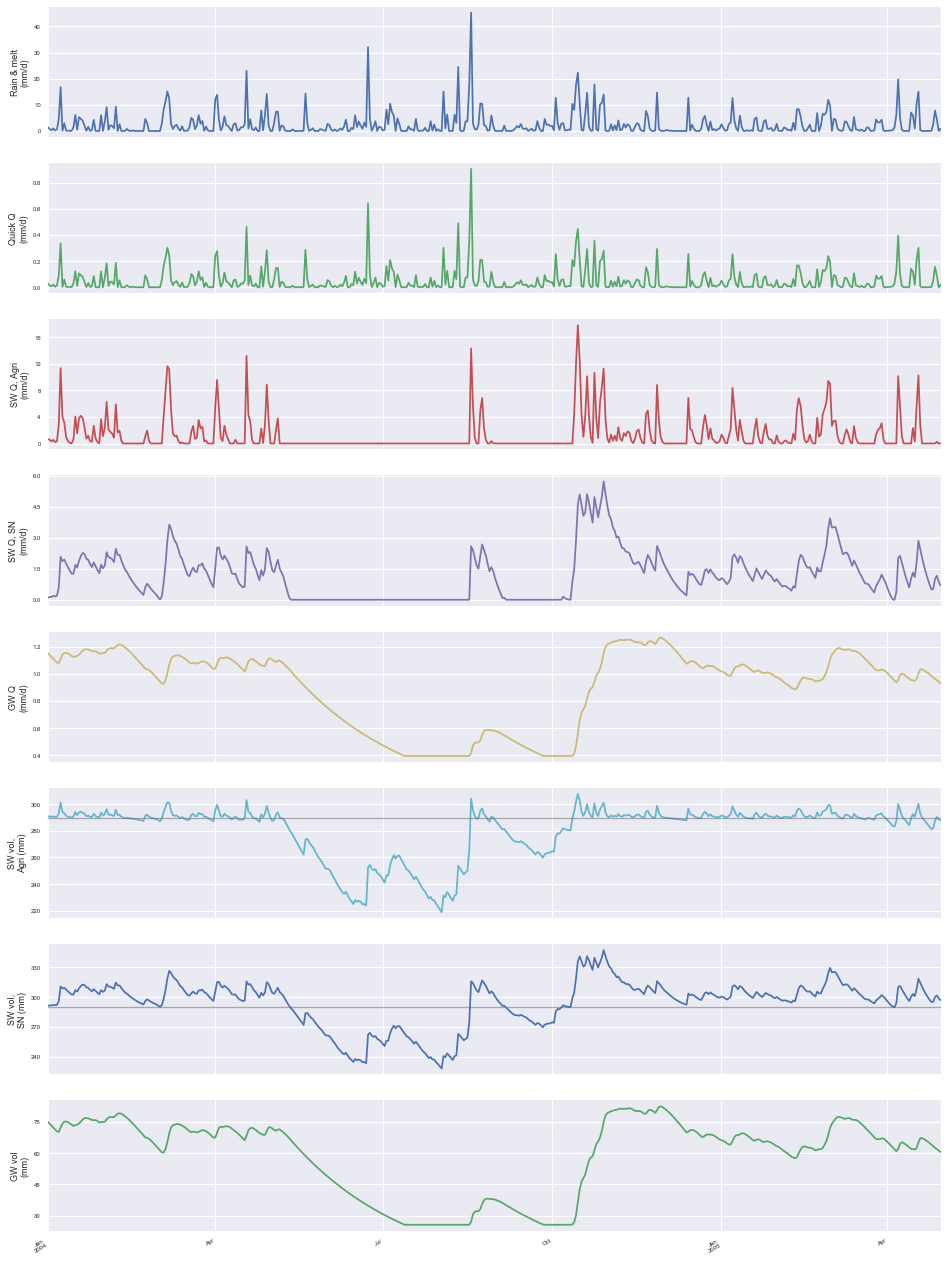

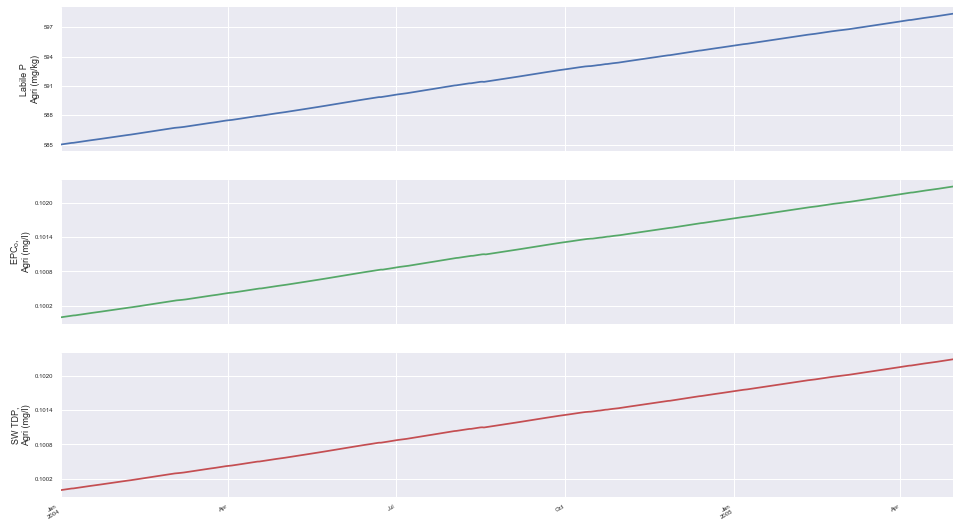

In [6]:
# Plot terrestrial
sp.plot_terrestrial(p_SU, p_SC, p, df_TC_dict, met_df, fig_display_type)

#### 4.3. Results from in-stream processing

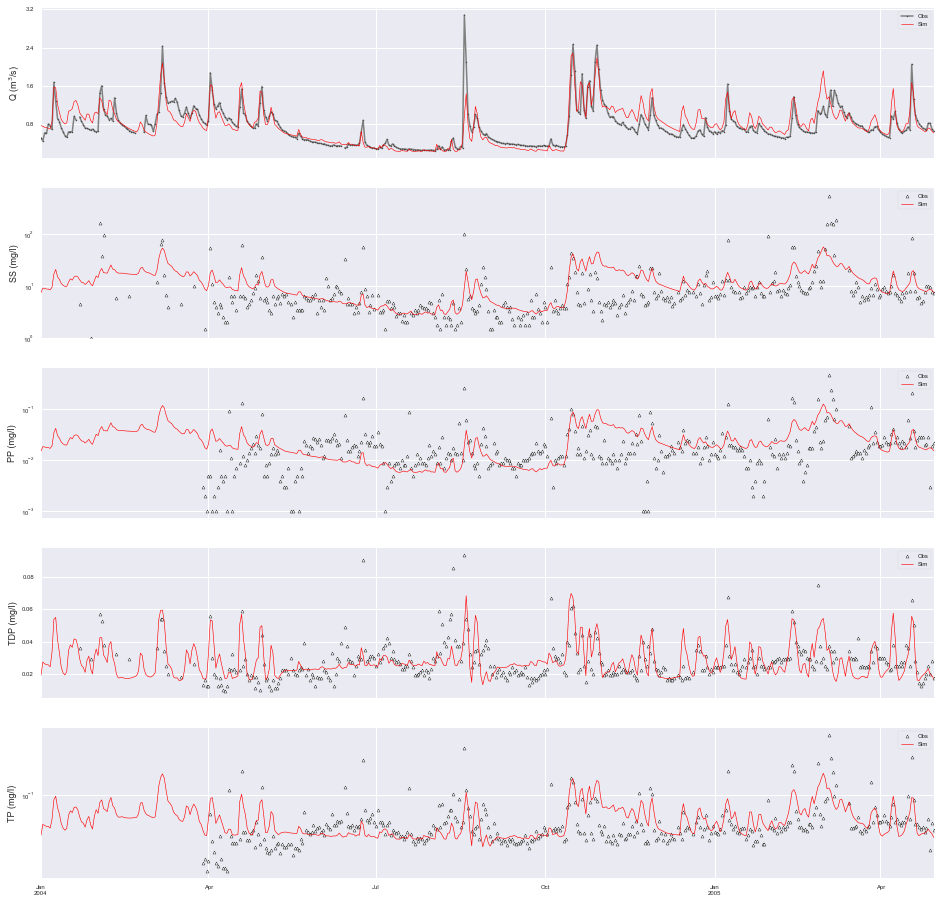

In [7]:
# Plot in-stream
sp.plot_in_stream(p_SU, obs_dict, df_R_dict, fig_display_type)

#### 4.4. Calculate goodness-of-fit statistics

In [8]:
# GoF summary
gof_stats = sp.goodness_of_fit_stats(p_SU, df_R_dict, obs_dict)
gof_stats

,N obs,NSE,log NSE,Spearmans r,r$^2$,Bias (%),nRMSD (%),Reach
Q,480,0.700317,0.778414,0.882307,0.729676,4.522245,37.019454,1
SS,398,0.125886,0.108279,0.560219,0.134733,-6.128860,28.618324,1
PP,384,0.107422,-0.268786,0.223533,0.129288,0.597721,48.024315,1
TDP,399,0.155863,0.074956,0.432152,0.285950,1.985728,64.982783,1
TP,384,0.161731,0.018652,0.288765,0.185495,1.641604,49.720417,1
